### Import Packages

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

### Preprocessing

In [30]:
df = pd.read_csv('data_output_extensive/player_season_stats_23-24_relevant.csv')
df.head(3)

,league,season,team,player,nation,pos,age,MP Playing Time,Min Playing Time,90s Playing Time,...,Won% Aerial Duels,Fls Performance,Fld Performance,Att Pen Touches,Att 3rd Touches,Mid 3rd Touches,Def 3rd Touches,Def Pen Touches,Live Touches,Cmp Total
0,ENG-Premier League,2324,Arsenal,Aaron Ramsdale,ENG,GK,25,6,540,6.0,...,NaN,0,1,0,0,11,186,140,197,131
1,ENG-Premier League,2324,Arsenal,Ben White,ENG,DF,25,37,2988,33.2,...,62.1,19,12,64,676,1165,633,120,2456,1828
2,ENG-Premier League,2324,Arsenal,Bukayo Saka,ENG,FW,21,35,2919,32.4,...,39.0,41,69,271,1310,474,182,37,1946,1143


#### Filter Players by Position

In [31]:
# Get Unique positions
unique_positions = df['pos'].unique()
print("Unique Positions:", unique_positions)

df_players = df[df['pos'] != 'GK']
print("Updated DataFrame shape (excluding GKs):", df_players['pos'].unique())

Unique Positions: ['GK' 'DF' 'FW' 'MF' 'MF,FW' 'FW,MF' 'MF,DF' 'DF,FW' 'FW,DF' 'DF,MF']
Updated DataFrame shape (excluding GKs): ['DF' 'FW' 'MF' 'MF,FW' 'FW,MF' 'MF,DF' 'DF,FW' 'FW,DF' 'DF,MF']


#### Remove Duplicated Players
(Those players who played for more than one team in a season)

In [32]:
# Identify duplicate players based on player name ('player')
duplicate_players = df_players[df_players.duplicated(subset=['player'], keep=False)]
print("Duplicate Players:\n", len(duplicate_players))

# Remove duplicate players, keeping the first appearance sorted by minutes played
df_players = df_players.sort_values('Min Playing Time', ascending=False)
df_players = df_players.drop_duplicates(subset=['player'], keep='first')
print("DataFrame shape after removing duplicates:", df_players.shape)

Duplicate Players:
 293
DataFrame shape after removing duplicates: (2502, 54)


#### Filter Players by Playing Time and Maches Played

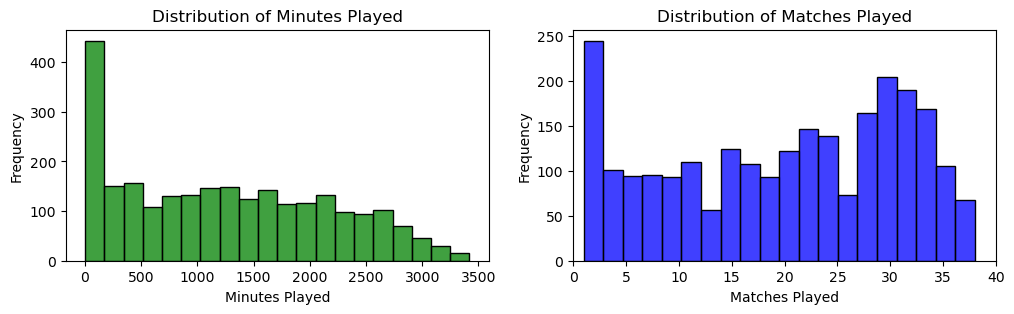

In [33]:
# Plot Distribution of Min Playing Time and MP Playing Time side by side
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
sns.histplot(df_players['Min Playing Time'],bins=20, color='green', kde=False)
plt.title('Distribution of Minutes Played')
plt.xlabel('Minutes Played')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
sns.histplot(df_players['MP Playing Time'],bins=20, color='blue', kde=False)
plt.xlim(0, 40)
plt.title('Distribution of Matches Played')
plt.xlabel('Matches Played')
plt.ylabel('Frequency')
plt.show()



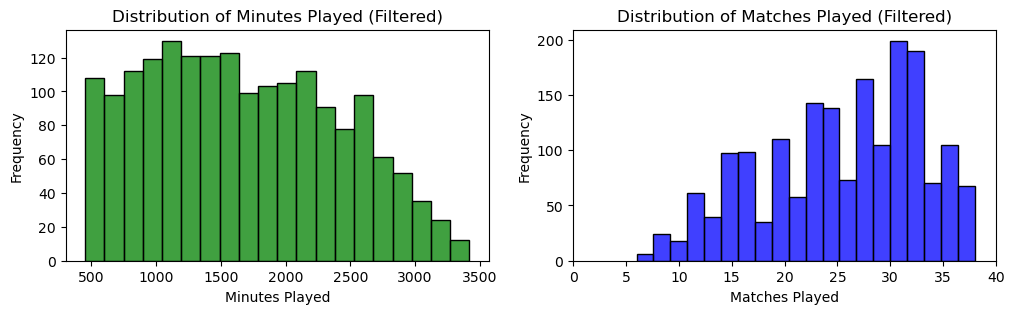

In [34]:
# Remove players with less than 450 minutes played and less than 5 matches played
df_players_filtered = df_players[(df_players['Min Playing Time'] >= 450) & (df_players['MP Playing Time'] >= 5)]

# Plot Distribution of Min Playing Time and MP Playing Time after filtering
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
sns.histplot(df_players_filtered['Min Playing Time'], bins=20, color='green', kde=False)
plt.title('Distribution of Minutes Played (Filtered)')
plt.xlabel('Minutes Played')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
sns.histplot(df_players_filtered['MP Playing Time'], bins=20, color='blue', kde=False)
plt.title('Distribution of Matches Played (Filtered)')
plt.xlim(0, 40)
plt.xlabel('Matches Played')
plt.ylabel('Frequency')
plt.show()

### Data Preparation for Clustering

In [35]:
# Find nan values in numeric_df
nan_counts = df_players_filtered.isna().sum()
print("NaN values in numeric DataFrame:\n", nan_counts[nan_counts > 0])

# Find if players with NaN values in one column have NaN values in other columns
nan_players = df_players_filtered[df_players_filtered.isna().any(axis=1)]
print("\nPlayers with NaN values:\n", len(nan_players))

NaN values in numeric DataFrame:
 nation                1
SoT% Standard        13
Dist Standard        13
G/Sh Standard        13
Succ% Take-Ons       22
Won% Aerial Duels     1
dtype: int64

Players with NaN values:
 37


In [36]:
# Remove rows with NaN values
df_players_filtered = df_players_filtered.dropna()
print("Numeric DataFrame shape after removing NaNs:", df_players_filtered.shape)

Numeric DataFrame shape after removing NaNs: (1765, 54)


#### Feature Processing

In [37]:
columns_90 = ['npxG Per 90 Minutes',
            'G-PK Per 90 Minutes',
            'xAG Per 90 Minutes',
            'xG+xAG Per 90 Minutes',
            'Sh/90 Standard',
            'SoT% Standard',
            "Dist Standard",
            "G/Sh Standard",
            "Cmp% Total",
            "Cmp% Long",
            "Succ% Take-Ons",
            'Won% Aerial Duels',
            ]

columns_to_90s = ['KP',
                    'PrgP',
                    'PPA',
                    'CrsPA',
                    '1/3',
                    'Att Long',
                    'TB Pass Types',
                    'Sw Pass Types',
                    'Crs Pass Types',
                    'PrgC Carries',
                    'CPA Carries',
                    'Succ Take-Ons',
                    'Dis Carries',
                    'Mis Carries',
                    'PrgR Receiving',
                    'TklW Tackles',
                    'Att 3rd Tackles',
                    'Mid 3rd Tackles',
                    'Def 3rd Tackles',
                    'Int',
                    'Sh Blocks',
                    'Recov Performance',
                    'Won Aerial Duels',
                    'Fls Performance',
                    'Fld Performance',
                    'Att Pen Touches',
                    'Att 3rd Touches',
                    'Mid 3rd Touches',
                    'Def 3rd Touches',
                    'Def Pen Touches',
                    'Live Touches',
                    'Cmp Total'
                    ]

print("Number of features: ", len(columns_90) + len(columns_to_90s))

Number of features:  44


In [38]:
# Check missing columns
missing_columns = [col for col in df_players_filtered.columns if col not in columns_90 + columns_to_90s]
print("Missing columns:", missing_columns)
# Missing columns are those that are not in the selected features list

Missing columns: ['league', 'season', 'team', 'player', 'nation', 'pos', 'age', 'MP Playing Time', 'Min Playing Time', '90s Playing Time']


In [39]:
# Scale Performance Metrics by 90s (minutes played / 90)
df_players_scaled = df_players_filtered.copy()
df_players_scaled[columns_to_90s] = df_players_scaled[columns_to_90s].div(df_players_scaled['90s Playing Time'], axis=0).round(2)

In [40]:
# Prepare final dataset for clustering
# Drop metadata columns AND playing time columns (not relevant for our clustering approach)
droping_columns = ['league', 'team', 'player', 'nation', 'pos', 'season', 'age', 
                   'MP Playing Time', 'Min Playing Time', '90s Playing Time']
df_players_final = df_players_scaled.drop(columns=droping_columns)

print(f"Final dataset: {df_players_final.shape[0]} players ; {df_players_final.shape[1]} features")
print(f"Features for clustering: {df_players_final.columns.tolist()}")

Final dataset: 1765 players ; 44 features
Features for clustering: ['npxG Per 90 Minutes', 'G-PK Per 90 Minutes', 'xAG Per 90 Minutes', 'xG+xAG Per 90 Minutes', 'Sh/90 Standard', 'SoT% Standard', 'Dist Standard', 'G/Sh Standard', 'KP', 'PrgP', 'PPA', 'CrsPA', '1/3', 'Cmp% Total', 'Cmp% Long', 'Att Long', 'TB Pass Types', 'Sw Pass Types', 'Crs Pass Types', 'PrgC Carries', 'CPA Carries', 'Succ Take-Ons', 'Succ% Take-Ons', 'Dis Carries', 'Mis Carries', 'PrgR Receiving', 'TklW Tackles', 'Att 3rd Tackles', 'Mid 3rd Tackles', 'Def 3rd Tackles', 'Int', 'Sh Blocks', 'Recov Performance', 'Won Aerial Duels', 'Won% Aerial Duels', 'Fls Performance', 'Fld Performance', 'Att Pen Touches', 'Att 3rd Touches', 'Mid 3rd Touches', 'Def 3rd Touches', 'Def Pen Touches', 'Live Touches', 'Cmp Total']


In [ ]:
# Quick check on numeric_df
df_players_final.head(3)

#### Assess Feature Correlations

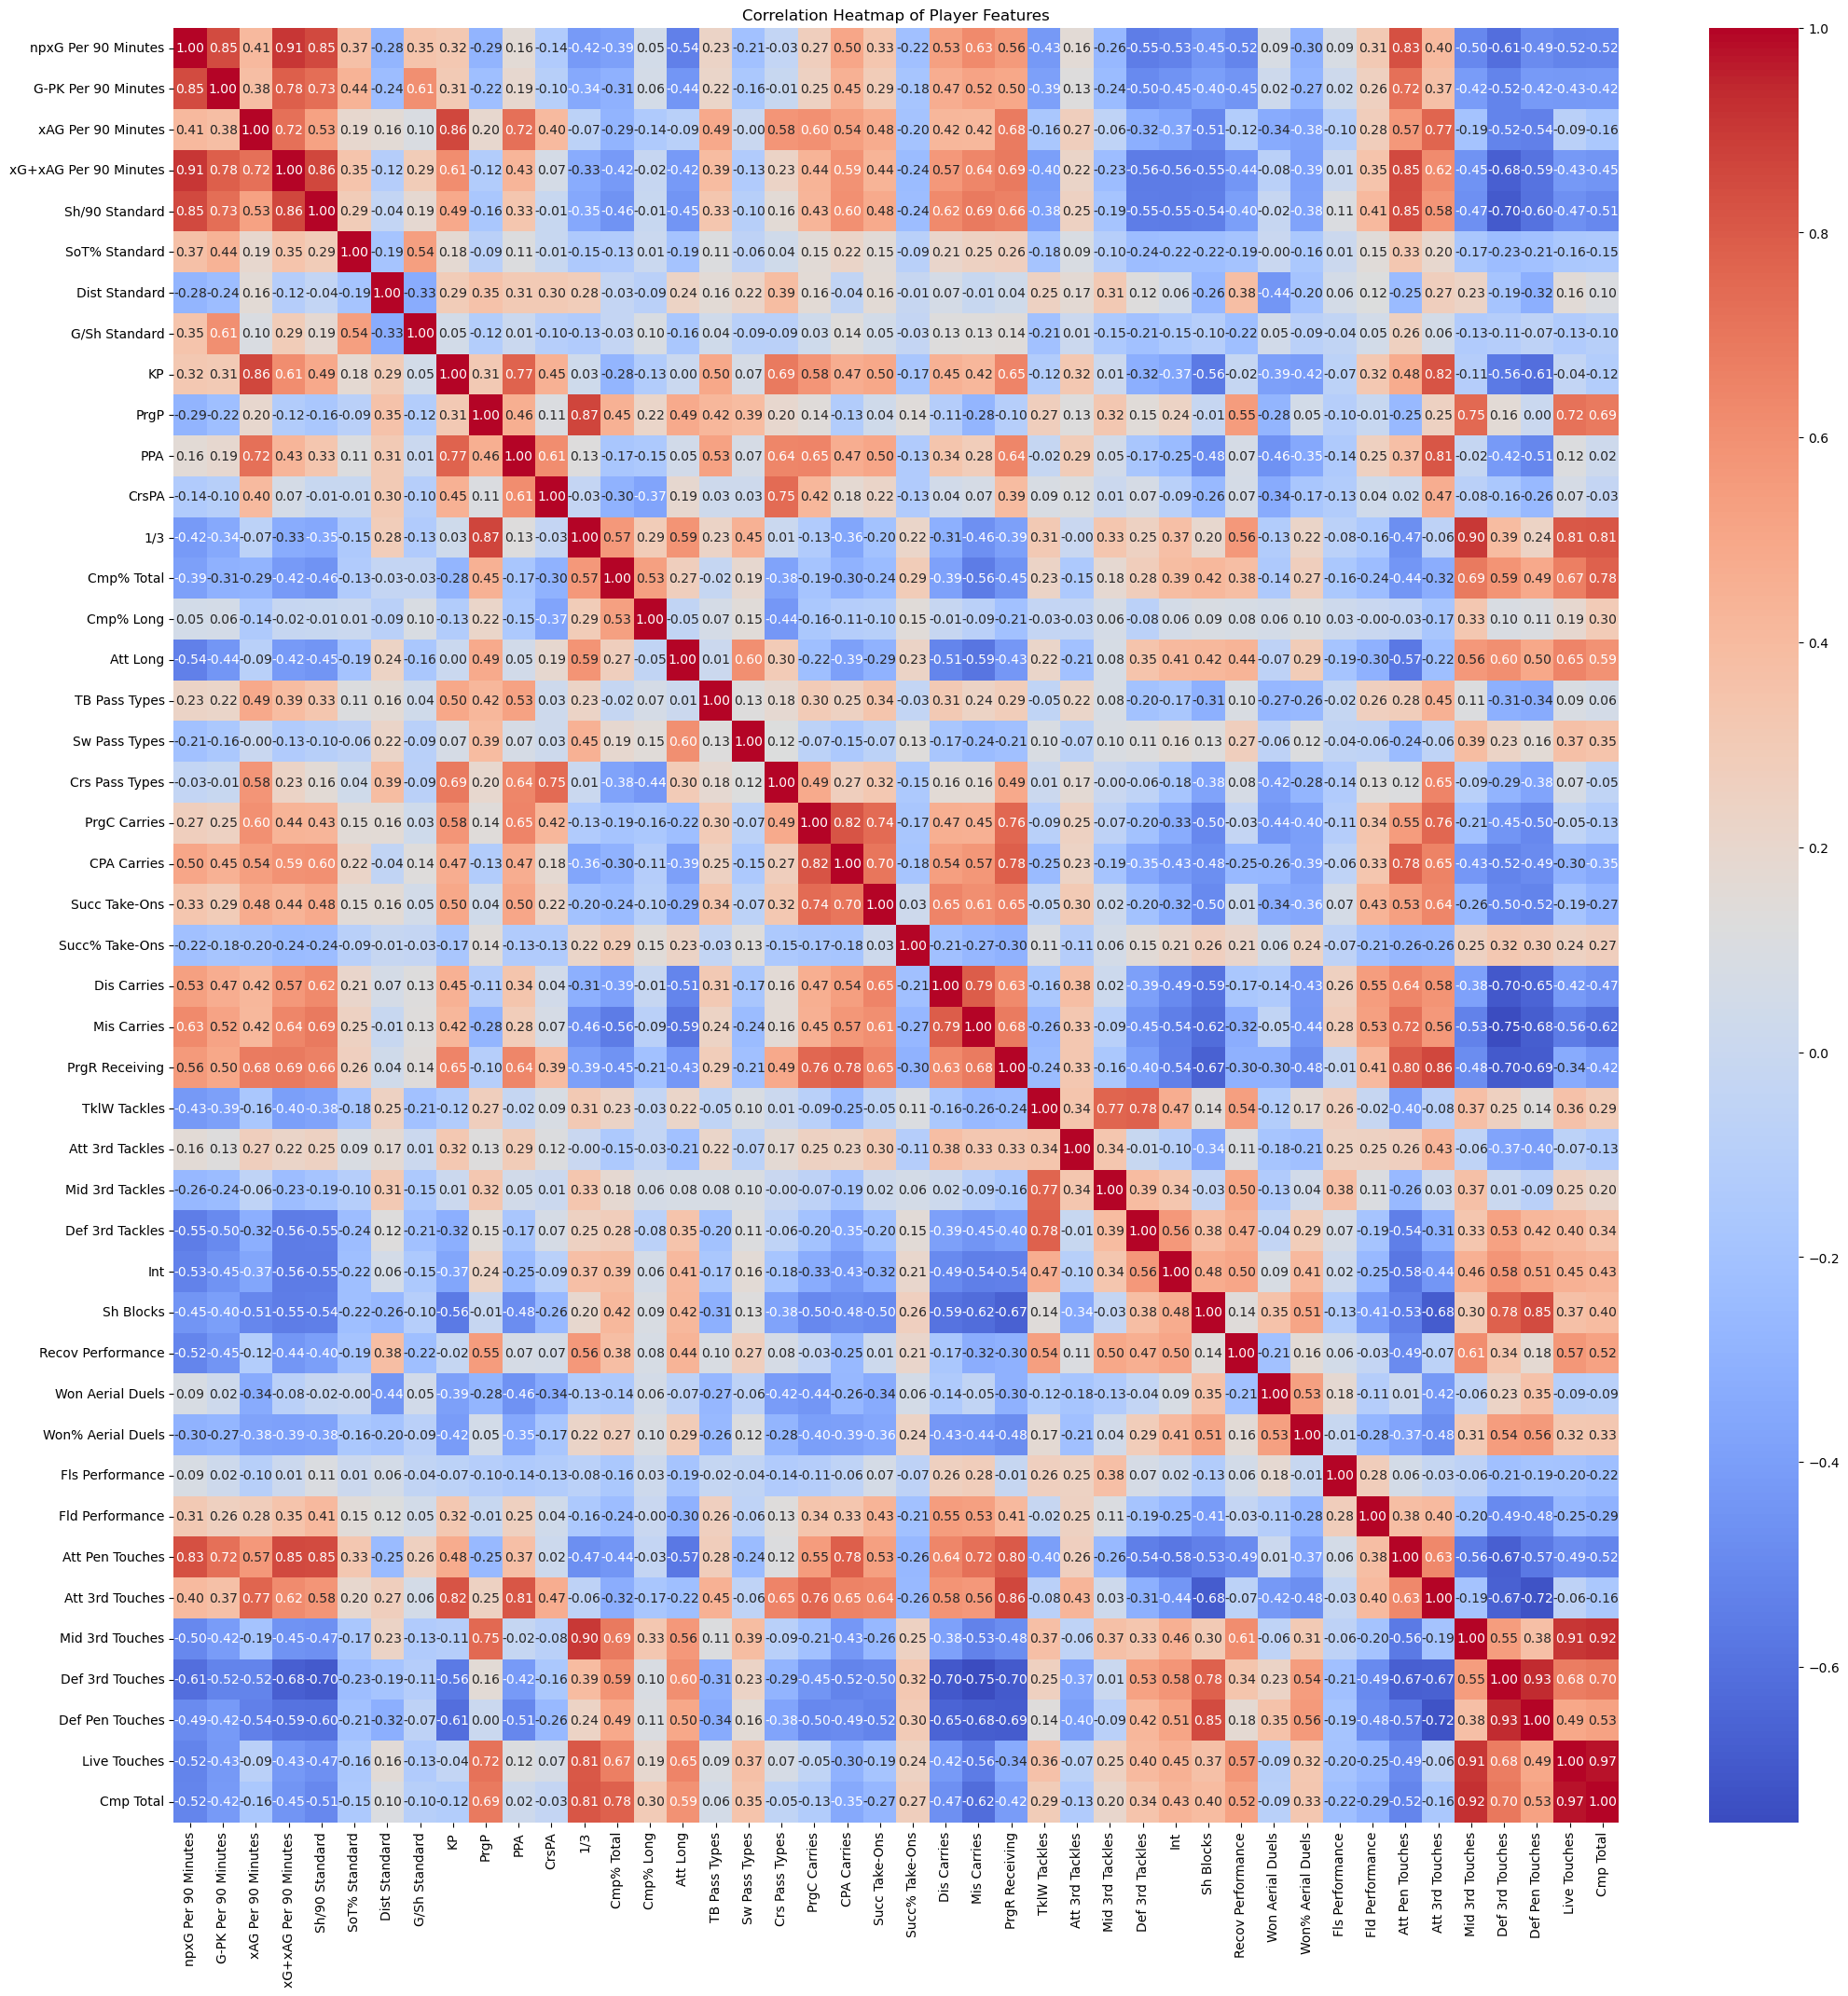

In [41]:
# Plot Correlation Heatmap
plt.figure(figsize=(25, 25))                    
sns.heatmap(df_players_final.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Player Features')
plt.show()

In [42]:
def identify_collinear_features(df, threshold=0.90):
    # Identify features that are highly correlated (above threshold).
        
    # Calculate correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find columns with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    for col in to_drop:
        # Find the feature it is correlated with
        correlated_with = upper.index[upper[col] > threshold].tolist()
        
        for partner in correlated_with:
            print(f"Conflict: {col} vs {partner}.")


identify_collinear_features(df_players_final, threshold=0.85)


Conflict: xG+xAG Per 90 Minutes vs npxG Per 90 Minutes.
Conflict: Sh/90 Standard vs npxG Per 90 Minutes.
Conflict: Sh/90 Standard vs xG+xAG Per 90 Minutes.
Conflict: KP vs xAG Per 90 Minutes.
Conflict: 1/3 vs PrgP.
Conflict: Att 3rd Touches vs PrgR Receiving.
Conflict: Mid 3rd Touches vs 1/3.
Conflict: Def Pen Touches vs Def 3rd Touches.
Conflict: Live Touches vs Mid 3rd Touches.
Conflict: Cmp Total vs Mid 3rd Touches.
Conflict: Cmp Total vs Live Touches.


In [43]:
columns_to_drop_from_corr = [
    # Attack Redundancies
    'xG+xAG Per 90 Minutes',  # We kept npxG and xAG separately
    'Sh/90 Standard',         # We kept npxG (Quality over Quantity)
    
    # Playmaking Redundancies
    'KP',                     # We kept xAG (Quality over Quantity)
    
    # Progression Redundancies
    '1/3',                    # We kept PrgP (Intent) and Mid 3rd (Location)
    'Att 3rd Touches',        # We kept PrgR (Role) and Att Pen Touches (Location)
    
    # Defensive/Volume Redundancies
    'Def 3rd Touches',        # We kept Def Pen Touches (Specific to CBs)
    'Live Touches',           # Pure volume metric (biased by team possession)
    'Cmp Total'               # Pure volume metric
]
df_players_final = df_players_final.drop(columns=columns_to_drop_from_corr)
print(f"Dataset shape after dropping collinear features: {df_players_final.shape}")

Dataset shape after dropping collinear features: (1765, 36)


### PCA

In [44]:
# Standardize the data
scaler = StandardScaler()
numeric_df_scaled = scaler.fit_transform(df_players_final)   

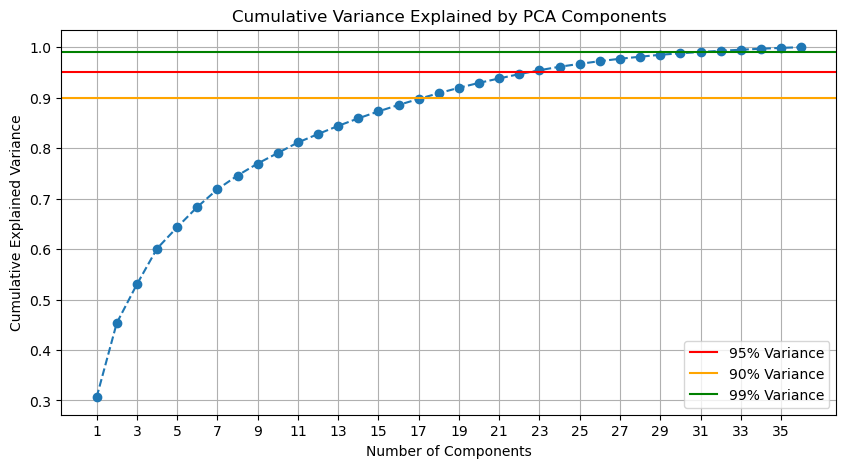

Number of components for 90% variance: 18
Number of components for 95% variance: 23
Number of components for 99% variance: 31


In [45]:
def cumulative_variance_pca(numeric_df_scaled):
    # Perform PCA for dimensionality reduction
    pca = PCA()
    pca_transformed = pca.fit_transform(numeric_df_scaled)

    # Calculate cumulative variance explained
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Plot cumulative variance explained
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Variance Explained by PCA Components')
    plt.grid(True)
    plt.axhline(y=0.95, color='r', linestyle='-', label='95% Variance')
    plt.axhline(y=0.90, color='orange', linestyle='-', label='90% Variance')
    plt.axhline(y=0.99, color='green', linestyle='-', label='99% Variance')
    plt.xticks(range(1, len(cumulative_variance) + 1, 2))
    plt.legend()
    plt.show()

    print(f"Number of components for 90% variance: {np.argmax(cumulative_variance >= 0.90) + 1}")
    print(f"Number of components for 95% variance: {np.argmax(cumulative_variance >= 0.95) + 1}")
    print(f"Number of components for 99% variance: {np.argmax(cumulative_variance >= 0.99) + 1}")

    return pca, pca_transformed, cumulative_variance
pca, pca_transformed, cumulative_variance= cumulative_variance_pca(numeric_df_scaled)

In [46]:
# Get the number of components for 90% variance
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

# Get the feature loadings (components) for those principal components
components_90 = pca.components_[:n_components_90]
# Get feature names
feature_names = df_players_final.columns.tolist()

# For each principal component, show the top contributing features
for i in range(5): #n_components_90
    # Get absolute loadings for this component
    loadings = np.abs(components_90[i])
    
    # Get indices of top 5 features
    top_indices = np.argsort(loadings)[-5:][::-1]
    
    print(f"\nPrincipal Component {i+1} (explains {pca.explained_variance_ratio_[i]:.2%} variance):")
    print("Top 5 contributing features:")
    for idx in top_indices:
        print(f"  {feature_names[idx]}: {components_90[i, idx]:.3f}")


Principal Component 1 (explains 30.65% variance):
Top 5 contributing features:
  PrgR Receiving: 0.269
  Att Pen Touches: 0.263
  Mis Carries: 0.249
  Def Pen Touches: -0.241
  CPA Carries: 0.233

Principal Component 2 (explains 14.71% variance):
Top 5 contributing features:
  PrgP: 0.302
  Dist Standard: 0.288
  PPA: 0.279
  Recov Performance: 0.273
  Crs Pass Types: 0.262

Principal Component 3 (explains 7.66% variance):
Top 5 contributing features:
  Fls Performance: 0.393
  Mid 3rd Tackles: 0.381
  TklW Tackles: 0.307
  Crs Pass Types: -0.281
  Att 3rd Tackles: 0.273

Principal Component 4 (explains 7.08% variance):
Top 5 contributing features:
  Cmp% Long: 0.391
  Cmp% Total: 0.351
  PrgP: 0.321
  Mid 3rd Touches: 0.283
  TB Pass Types: 0.278

Principal Component 5 (explains 4.22% variance):
Top 5 contributing features:
  G/Sh Standard: 0.429
  SoT% Standard: 0.373
  Dist Standard: -0.301
  Def 3rd Tackles: 0.300
  TklW Tackles: 0.286


In [47]:
# Work with first n_components_90 principal components
pca_final = PCA(n_components=n_components_90)
pca_final_transformed = pca_final.fit_transform(numeric_df_scaled)


### Clustering Methods

#### K-Means

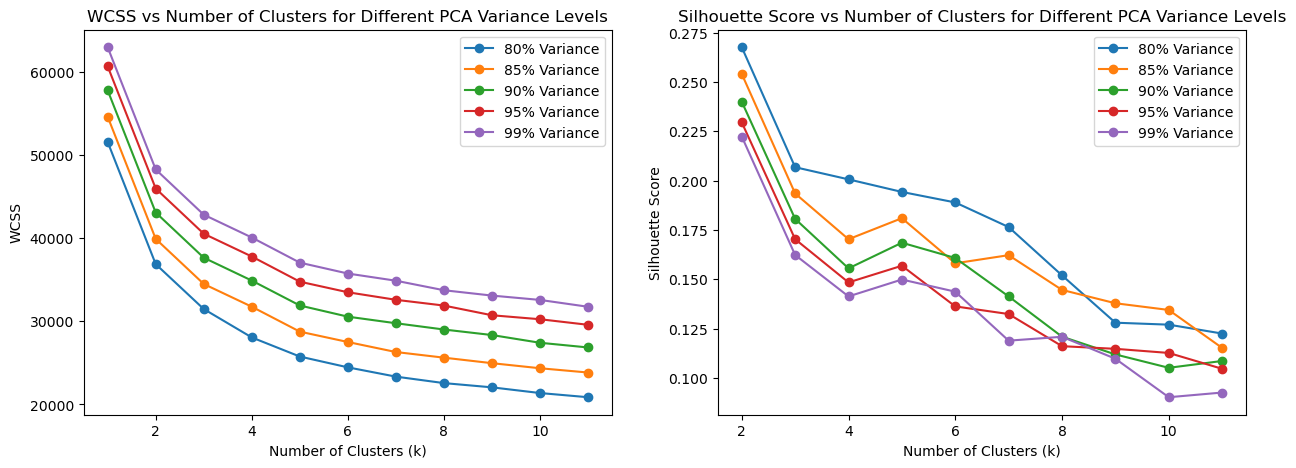

In [48]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
percentiles = [80,85,90,95,99]
wcss = []
silhouette_scores = []
for perc in percentiles:
    n_componnet = np.argmax(cumulative_variance >= perc/100) + 1
    pca_data = PCA(n_components=n_componnet).fit_transform(numeric_df_scaled)
    wcss_perc = []
    silhouette_scores_perc = []
    for k in range(1,12):
        kmean = KMeans(n_clusters=k, init='k-means++', random_state=42)
        kmean.fit(pca_data)
        wcss_perc.append(kmean.inertia_)
        if k > 1:
            labels = k
            silhouette_avg = silhouette_score(pca_data, kmean.labels_)
            silhouette_scores_perc.append(silhouette_avg)
    wcss.append(wcss_perc)
    silhouette_scores.append(silhouette_scores_perc)

# Subplot side by side  WCSS and silhouette scores for different percentiles and k values
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for i, perc in enumerate(percentiles):
    plt.plot(range(1, 12), wcss[i], marker='o', label=f'{perc}% Variance')
plt.title('WCSS vs Number of Clusters for Different PCA Variance Levels')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.legend()
plt.subplot(1, 2, 2)
for i, perc in enumerate(percentiles):
    plt.plot(range(2, 12), silhouette_scores[i], marker='o', label=f'{perc}% Variance')
plt.title('Silhouette Score vs Number of Clusters for Different PCA Variance Levels')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()

#### DBASCAN

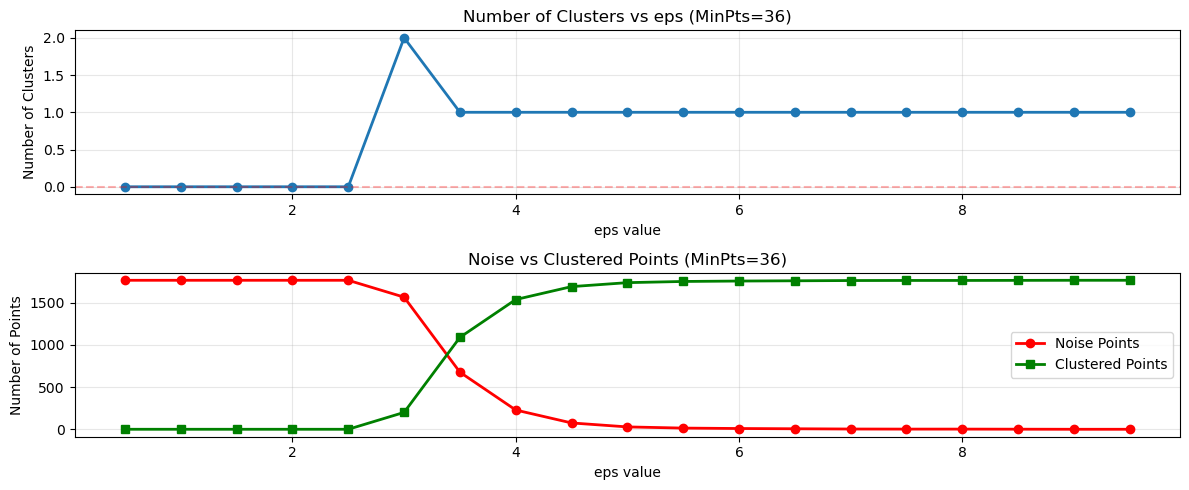

In [52]:
# Test different eps values and track number of clusters
eps_values = np.arange(0.5, 10, 0.5)
n_clusters_list = []
n_noise_list = []
cluster_info = []
minPts = n_components_90*2

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=minPts)
    labels = dbscan.fit_predict(pca_final_transformed)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    n_clusters_list.append(n_clusters)
    n_noise_list.append(n_noise)
    cluster_info.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'n_clustered': len(labels) - n_noise
    })

# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 5))

# Plot 1: Number of clusters vs eps
axes[0].plot(eps_values, n_clusters_list, marker='o', linewidth=2, markersize=6)
axes[0].set_xlabel('eps value')
axes[0].set_ylabel('Number of Clusters')
axes[0].set_title(f'Number of Clusters vs eps (MinPts={minPts})')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.3)

# Plot 2: Number of noise points and clustered points vs eps
axes[1].plot(eps_values, n_noise_list, marker='o', linewidth=2, markersize=6, label='Noise Points', color='red')
axes[1].plot(eps_values, [len(pca_final_transformed) - n for n in n_noise_list], 
             marker='s', linewidth=2, markersize=6, label='Clustered Points', color='green')
axes[1].set_xlabel('eps value')
axes[1].set_ylabel('Number of Points')
axes[1].set_title(f'Noise vs Clustered Points (MinPts={minPts})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### DBSCAN Parameter Grid Search Across PCA Variance Levels

In [53]:
percentiles = [80,85,90,95,99]
eps_values = np.arange(0.5, 10, 0.5)

global_cluster_list = []
global_noise_info = []
global_clustered_info = []
components_list = []
for p in percentiles:
    # Get the number of components for the given percentile
    n_componnet = np.argmax(cumulative_variance >= p/100) + 1
    components_list.append(n_componnet)
    pca_data = PCA(n_components=n_componnet).fit_transform(numeric_df_scaled)
    
    # Calculate MinPts range
    minPts = np.arange(6, 2*n_componnet, 2)
    eps_cluster_list = []
    eps_noise_info = []
    eps_clustered_info = []
    for minPts_val in minPts:
        n_clusters_list = []
        n_noise_list = []
        n_cluster_info = []
        for eps in eps_values:
            dbscan = DBSCAN(eps=eps, min_samples=minPts_val)
            labels = dbscan.fit_predict(pca_data)
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            n_clusters_list.append(n_clusters)
            n_noise_list.append(n_noise)
            n_cluster_info.append({
                'eps': eps,
                'minPts': minPts_val,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'n_clustered': len(labels) - n_noise
            })
        eps_cluster_list.append(n_clusters_list)
        eps_noise_info.append(n_noise_list)
        eps_clustered_info.append(n_cluster_info)
        
    global_cluster_list.append(eps_cluster_list)
    global_noise_info.append(eps_noise_info)
    global_clustered_info.append(eps_clustered_info)
        
# Now global_cluster_list, global_noise_info, and global_clustered_info
# contain the clustering results for each percentile, eps, and minPts combination


In [ ]:
# Plot Results for each percentile
total_points = len(pca_data)
for i, p in enumerate(percentiles):
    fig, axes = plt.subplots(2, 1, figsize=(12, 5))
    # Plot 1: Number of clusters vs eps for different MinPts
    for j, minPts_val in enumerate(range(6, 2*components_list[i], 2)):
        # Plot 1: Number of clusters vs eps
        axes[0].plot(eps_values, global_cluster_list[i][j], marker='o', linewidth=2, markersize=6, label=f'MinPts={minPts_val}')
        
        # Plot 2: Noise points vs clustered points
        axes[1].plot(eps_values, global_noise_info[i][j], marker='o', linewidth=2, markersize=6, label=f'MinPts={minPts_val}')
        axes[1].plot(eps_values, [total_points - n for n in global_noise_info[i][j]], marker='s', linewidth=2, markersize=6, label=f'Clustered (MinPts={minPts_val})')
    
    # Plot 1 settings
    axes[0].set_xlabel('eps value')
    axes[0].set_ylabel('Number of Clusters')
    axes[0].set_title(f'Number of Clusters vs eps (PCA {p}%, MinPts range)')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
    axes[0].legend()      
    
    # Plot 2 settings
    axes[1].set_xlabel('eps value')
    axes[1].set_ylabel('Number of Points')
    axes[1].set_title(f'Noise vs Clustered Points (PCA {p}%, MinPts range)')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()


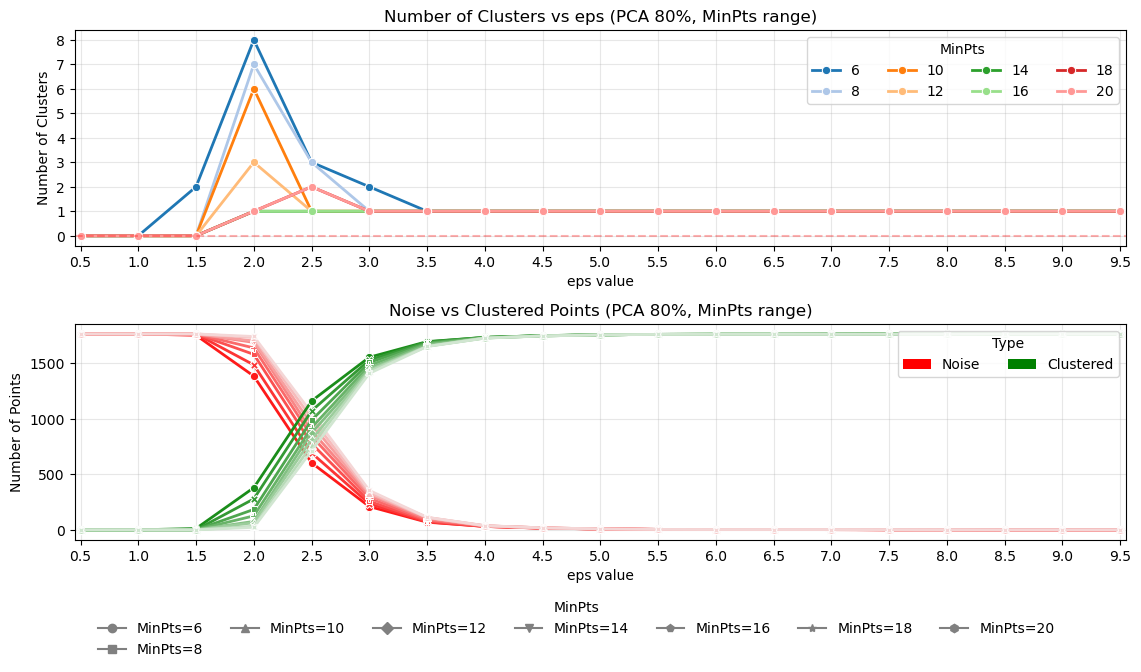

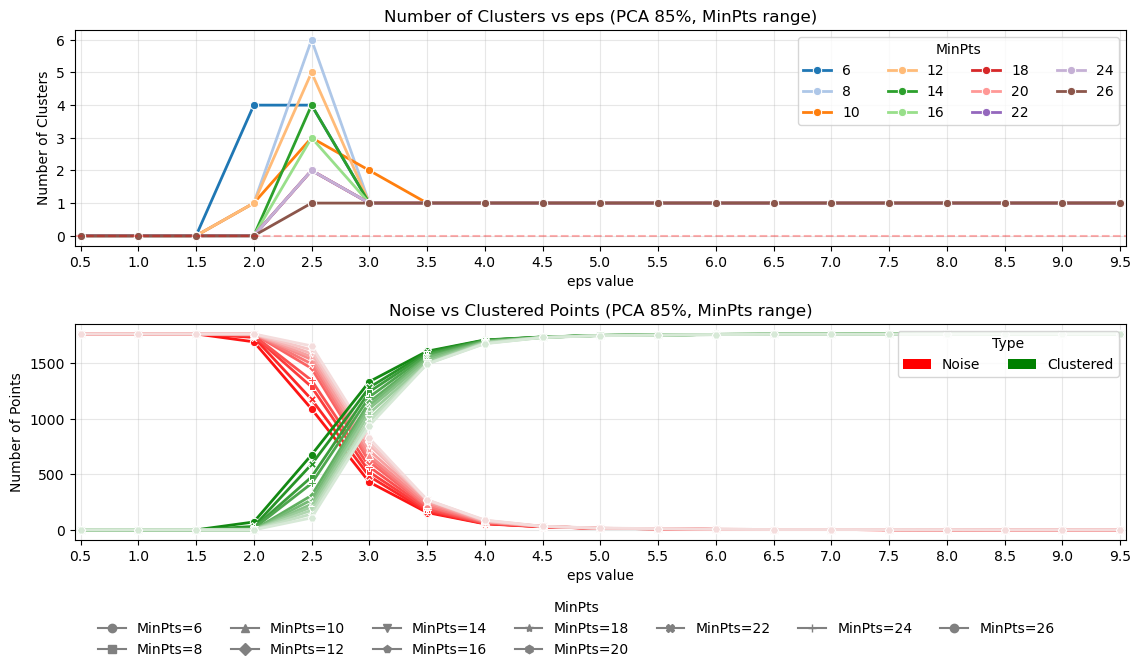

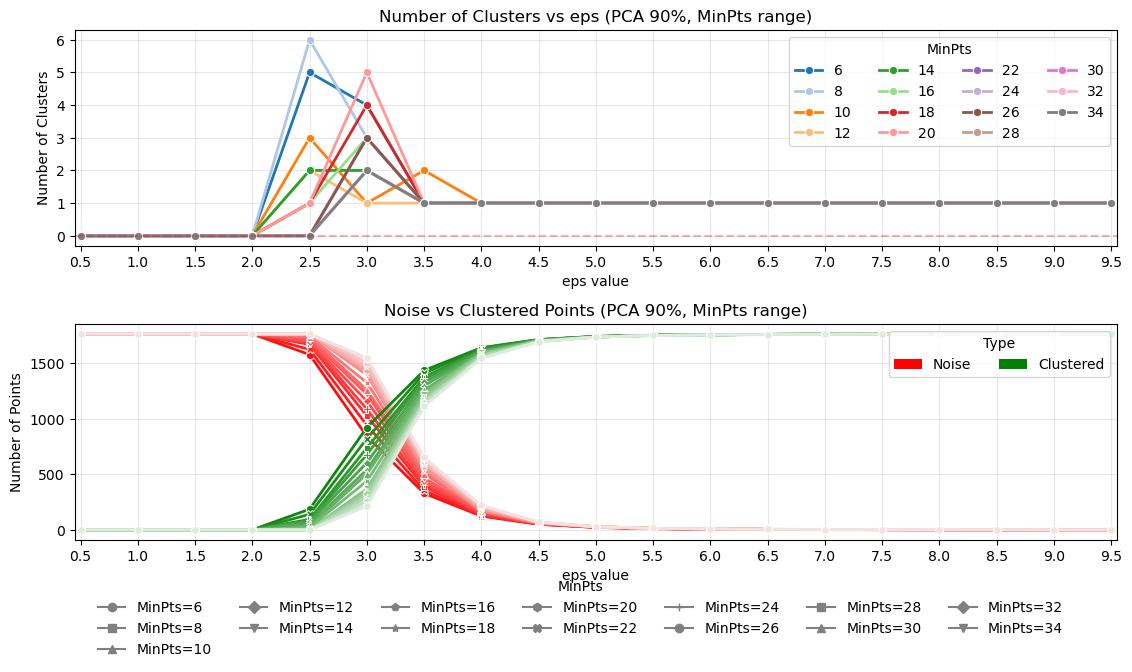

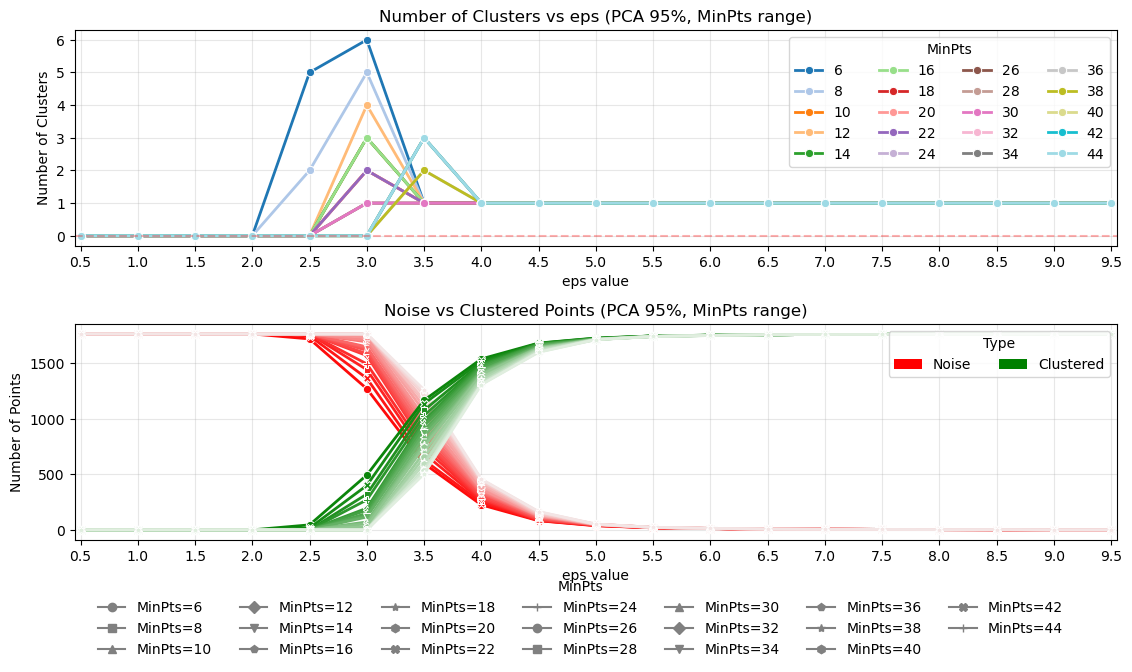

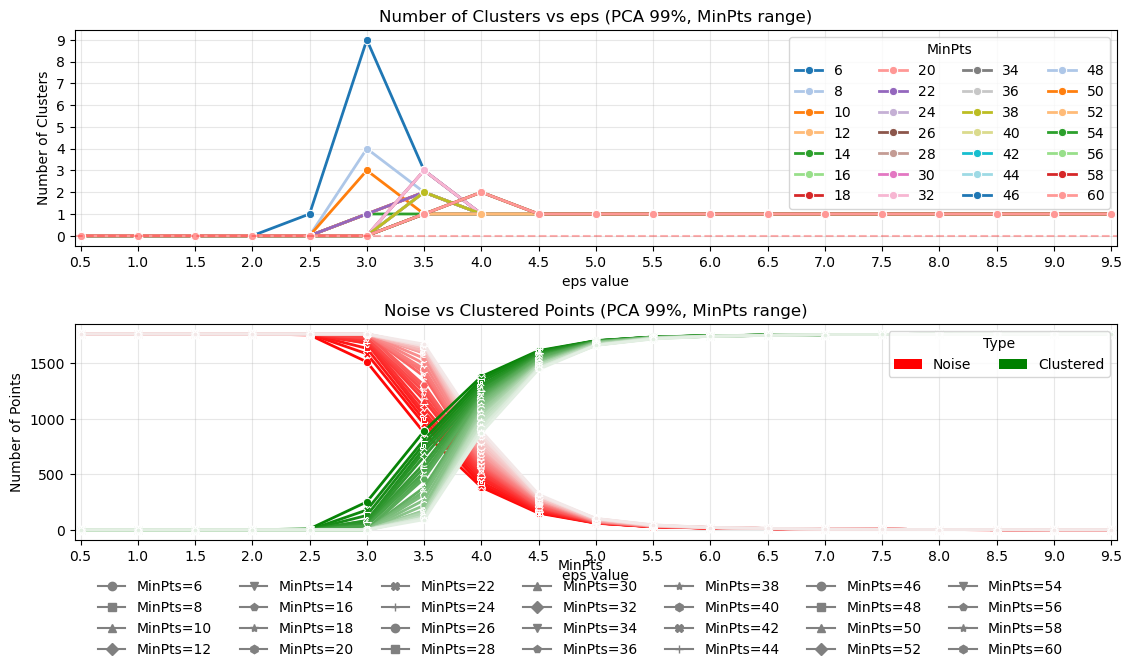

In [55]:
# Plot Results for each percentile using Seaborn
total_points = len(pca_data)

for i, p in enumerate(percentiles):
    # Prepare data for seaborn
    plot_data = []
    
    for j, minPts_val in enumerate(range(6, 2*components_list[i], 2)):
        for k, eps in enumerate(eps_values):
            plot_data.append({
                'eps': eps,
                'MinPts': minPts_val,
                'n_clusters': global_cluster_list[i][j][k],
                'noise': global_noise_info[i][j][k],
                'clustered': total_points - global_noise_info[i][j][k]
            })
    
    df_plot = pd.DataFrame(plot_data)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 7))
    
    # Plot 1: Number of clusters vs eps
    sns.lineplot(data=df_plot, x='eps', y='n_clusters', hue='MinPts', 
                 marker='o', linewidth=2, markersize=6, palette='tab20', ax=axes[0])
    axes[0].set_xlabel('eps value')
    axes[0].set_xticks(eps_values)
    axes[0].set_xlim(eps_values[0]-0.05, eps_values[-1]+0.05)
    axes[0].set_ylabel('Number of Clusters')
    axes[0].set_yticks(range(0, df_plot['n_clusters'].max()+1))
    axes[0].set_title(f'Number of Clusters vs eps (PCA {p}%, MinPts range)')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
    axes[0].legend(title='MinPts',loc='upper right', ncol=4)
    
    # Plot 2: Noise and clustered points vs eps
    df_long = pd.melt(df_plot, id_vars=['eps', 'MinPts'], 
                      value_vars=['noise', 'clustered'],
                      var_name='point_type', value_name='count')
    
    # Generate shades of red for noise and green for clustered
    minpts_unique = sorted(df_long['MinPts'].unique())
    n_minpts = len(minpts_unique)
    noise_palette = sns.light_palette("red", n_colors=n_minpts+2, reverse=True)[1:-1]
    clustered_palette = sns.light_palette("green", n_colors=n_minpts+2, reverse=True)[1:-1]
    
    # Create combined palette
    combined_palette = {}
    for idx, minpts in enumerate(minpts_unique):
        combined_palette[f'noise_{minpts}'] = noise_palette[idx]
        combined_palette[f'clustered_{minpts}'] = clustered_palette[idx]
    
    # Create combined hue column
    df_long['hue_combined'] = df_long['point_type'] + '_' + df_long['MinPts'].astype(str)
    
    # Convert MinPts to string for style mapping
    df_long['MinPts_str'] = df_long['MinPts'].astype(str)
    
    sns.lineplot(data=df_long, x='eps', y='count', hue='hue_combined', style='MinPts_str',
                 markers=True, dashes=False, linewidth=2, markersize=6, 
                 palette=combined_palette, ax=axes[1], legend=False)
    
    # Create custom legend
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    
    # Color legend (point types)
    color_elements = [
        Patch(facecolor='red', label='Noise'),
        Patch(facecolor='green', label='Clustered')
    ]
    
    # Marker legend (MinPts values) - get actual markers used by seaborn
    marker_styles = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', 'X', '+']
    marker_elements = [
        Line2D([0], [0], color='gray', marker=marker_styles[i % len(marker_styles)], 
               linestyle='-', markersize=6, label=f'MinPts={minpts}')
        for i, minpts in enumerate(minpts_unique)
    ]
    
    axes[1].set_xlabel('eps value')
    axes[1].set_xticks(eps_values)
    axes[1].set_xlim(eps_values[0]-0.05, eps_values[-1]+0.05)
    axes[1].set_ylabel('Number of Points')
    axes[1].set_title(f'Noise vs Clustered Points (PCA {p}%, MinPts range)')
    axes[1].grid(True, alpha=0.3)
    
    # Add two separate legends
    first_legend = axes[1].legend(handles=color_elements, title='Type', 
                                   loc='upper right', ncol=2, frameon=True)
    axes[1].add_artist(first_legend)
    axes[1].legend(handles=marker_elements, title='MinPts',
                   loc='lower left', bbox_to_anchor=(0.01, -0.6), ncol=7, frameon=False)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Comprehensive DBSCAN parameter search across different PCA variance levels
percentiles = [80, 85, 90, 95, 99]
eps_values = np.arange(0.5, 10, 0.5)

all_results = []

print("="*80)
print("DBSCAN PARAMETER GRID SEARCH ACROSS PCA VARIANCE LEVELS")
print("="*80)

for perc in percentiles:
    # Get number of components for this percentile
    n_components = np.argmax(cumulative_variance >= perc/100) + 1
    
    # Perform PCA with this number of components
    pca_temp = PCA(n_components=n_components)
    pca_data_temp = pca_temp.fit_transform(numeric_df_scaled)
    
    # Define minPts range for this variance level
    minPts_values = range(6, n_components * 2 + 1)
    
    print(f"\n{'='*80}")
    print(f"PCA Variance: {perc}% ({n_components} components)")
    print(f"MinPts range: {min(minPts_values)} to {max(minPts_values)}")
    print(f"{'='*80}")
    
    best_config = None
    best_silhouette = -1
    
    # Grid search over eps and minPts
    for eps in eps_values:
        for minPts in minPts_values:
            dbscan = DBSCAN(eps=eps, min_samples=minPts)
            labels = dbscan.fit_predict(pca_data_temp)
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            n_clustered = len(labels) - n_noise
            
            # Calculate silhouette score if valid clustering
            silhouette = None
            if n_clusters >= 2 and n_clustered > 10:
                core_samples_mask = labels != -1
                unique_clustered_labels = len(set(labels[core_samples_mask]))
                
                if unique_clustered_labels >= 2:
                    silhouette = silhouette_score(pca_data_temp[core_samples_mask], 
                                                  labels[core_samples_mask])
                    
                    if silhouette > best_silhouette:
                        best_silhouette = silhouette
                        best_config = {
                            'eps': eps,
                            'minPts': minPts,
                            'n_clusters': n_clusters,
                            'n_noise': n_noise,
                            'n_clustered': n_clustered,
                            'silhouette': silhouette
                        }
            
            # Store results
            all_results.append({
                'variance': perc,
                'n_components': n_components,
                'eps': eps,
                'minPts': minPts,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'n_clustered': n_clustered,
                'noise_ratio': n_noise / len(labels),
                'silhouette': silhouette
            })
    
    # Print best configuration for this variance level
    if best_config:
        print(f"\nBest configuration for {perc}% variance:")
        print(f"  eps={best_config['eps']:.2f}, MinPts={best_config['minPts']}")
        print(f"  Clusters: {best_config['n_clusters']}, Noise: {best_config['n_noise']}, "
              f"Clustered: {best_config['n_clustered']}")
        print(f"  Silhouette Score: {best_config['silhouette']:.4f}")
    else:
        print(f"\nNo valid clustering found for {perc}% variance")

print(f"\n{'='*80}")
print("GRID SEARCH COMPLETE")
print(f"{'='*80}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(all_results)
print(f"\nTotal configurations tested: {len(results_df)}")
print(f"Valid clusterings (silhouette calculated): {results_df['silhouette'].notna().sum()}")

In [ ]:
# Visualize results across all variance levels
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, perc in enumerate(percentiles):
    perc_data = results_df[results_df['variance'] == perc]
    
    # Filter to only valid silhouette scores
    valid_data = perc_data[perc_data['silhouette'].notna()]
    
    if len(valid_data) > 0:
        # Create pivot table for heatmap
        pivot = valid_data.pivot_table(
            values='silhouette',
            index='minPts',
            columns='eps',
            aggfunc='first'
        )
        
        # Plot heatmap
        im = axes[idx].imshow(pivot.values, cmap='viridis', aspect='auto', 
                             vmin=results_df['silhouette'].min(), 
                             vmax=results_df['silhouette'].max())
        
        # Set ticks
        axes[idx].set_xticks(range(len(pivot.columns)))
        axes[idx].set_xticklabels([f'{x:.1f}' for x in pivot.columns], rotation=45)
        axes[idx].set_yticks(range(len(pivot.index)))
        axes[idx].set_yticklabels(pivot.index)
        
        axes[idx].set_xlabel('eps')
        axes[idx].set_ylabel('MinPts')
        n_comp = perc_data['n_components'].iloc[0]
        axes[idx].set_title(f'{perc}% Variance ({n_comp} components)')
        
        # Find and mark best configuration
        best_idx = valid_data['silhouette'].idxmax()
        best_row = valid_data.loc[best_idx]
        best_eps_idx = list(pivot.columns).index(best_row['eps'])
        best_minpts_idx = list(pivot.index).index(best_row['minPts'])
        
        axes[idx].scatter(best_eps_idx, best_minpts_idx, marker='*', 
                         s=500, c='red', edgecolors='white', linewidth=2)
    else:
        axes[idx].text(0.5, 0.5, f'{perc}% Variance\nNo valid clusterings', 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])

# Remove extra subplot
fig.delaxes(axes[-1])

# Add colorbar
fig.colorbar(im, ax=axes, label='Silhouette Score', fraction=0.046, pad=0.04)

plt.suptitle('DBSCAN Silhouette Scores Across PCA Variance Levels\n(Red star = Best configuration)', 
             fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

In [ ]:
# Summary statistics and best overall configuration
print("="*80)
print("OVERALL BEST CONFIGURATIONS BY VARIANCE LEVEL")
print("="*80)

best_by_variance = []

for perc in percentiles:
    perc_data = results_df[(results_df['variance'] == perc) & (results_df['silhouette'].notna())]
    
    if len(perc_data) > 0:
        best_idx = perc_data['silhouette'].idxmax()
        best_config = perc_data.loc[best_idx]
        best_by_variance.append(best_config)
        
        print(f"\n{perc}% Variance ({int(best_config['n_components'])} components):")
        print(f"  Best: eps={best_config['eps']:.1f}, MinPts={int(best_config['minPts'])}")
        print(f"  Silhouette: {best_config['silhouette']:.4f}")
        print(f"  Clusters: {int(best_config['n_clusters'])}, "
              f"Noise: {int(best_config['n_noise'])} ({best_config['noise_ratio']*100:.1f}%), "
              f"Clustered: {int(best_config['n_clustered'])}")

# Find absolute best configuration
if best_by_variance:
    best_overall = max(best_by_variance, key=lambda x: x['silhouette'])
    
    print(f"\n{'='*80}")
    print("ABSOLUTE BEST CONFIGURATION")
    print(f"{'='*80}")
    print(f"PCA Variance: {int(best_overall['variance'])}% ({int(best_overall['n_components'])} components)")
    print(f"DBSCAN: eps={best_overall['eps']:.1f}, MinPts={int(best_overall['minPts'])}")
    print(f"Silhouette Score: {best_overall['silhouette']:.4f}")
    print(f"Clusters: {int(best_overall['n_clusters'])}")
    print(f"Noise: {int(best_overall['n_noise'])} ({best_overall['noise_ratio']*100:.1f}%)")
    print(f"Clustered: {int(best_overall['n_clustered'])}")

# Plot comparison of best configurations across variance levels
best_df = pd.DataFrame(best_by_variance)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Silhouette score vs variance
axes[0, 0].plot(best_df['variance'], best_df['silhouette'], marker='o', 
               linewidth=2, markersize=10, color='steelblue')
axes[0, 0].set_xlabel('PCA Variance (%)')
axes[0, 0].set_ylabel('Best Silhouette Score')
axes[0, 0].set_title('Best Silhouette Score by PCA Variance Level')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(percentiles)

# Plot 2: Number of clusters vs variance
axes[0, 1].plot(best_df['variance'], best_df['n_clusters'], marker='s', 
               linewidth=2, markersize=10, color='darkgreen')
axes[0, 1].set_xlabel('PCA Variance (%)')
axes[0, 1].set_ylabel('Number of Clusters')
axes[0, 1].set_title('Number of Clusters by PCA Variance Level')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(percentiles)

# Plot 3: Noise ratio vs variance
axes[1, 0].plot(best_df['variance'], best_df['noise_ratio']*100, marker='^', 
               linewidth=2, markersize=10, color='red')
axes[1, 0].set_xlabel('PCA Variance (%)')
axes[1, 0].set_ylabel('Noise Ratio (%)')
axes[1, 0].set_title('Noise Ratio by PCA Variance Level')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(percentiles)

# Plot 4: Optimal parameters vs variance
ax2 = axes[1, 1].twinx()
axes[1, 1].plot(best_df['variance'], best_df['eps'], marker='o', 
               linewidth=2, markersize=10, color='blue', label='eps')
ax2.plot(best_df['variance'], best_df['minPts'], marker='s', 
         linewidth=2, markersize=10, color='orange', label='MinPts')
axes[1, 1].set_xlabel('PCA Variance (%)')
axes[1, 1].set_ylabel('Optimal eps', color='blue')
ax2.set_ylabel('Optimal MinPts', color='orange')
axes[1, 1].set_title('Optimal DBSCAN Parameters by PCA Variance Level')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(percentiles)
axes[1, 1].tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='orange')

# Add legends
axes[1, 1].legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

#### Gaussian Mixture Model (GMM)

Running GMM analysis for different cluster numbers and covariance types...
n_clusters=2, cov_type=full: Silhouette=0.2006, DBI=1.7967
n_clusters=2, cov_type=tied: Silhouette=0.2425, DBI=1.5993


n_clusters=2, cov_type=diag: Silhouette=0.2312, DBI=1.7266
n_clusters=2, cov_type=spherical: Silhouette=0.2405, DBI=1.6332
n_clusters=3, cov_type=full: Silhouette=0.1659, DBI=1.7774
n_clusters=3, cov_type=tied: Silhouette=0.1762, DBI=1.7062
n_clusters=3, cov_type=diag: Silhouette=0.1616, DBI=1.7721
n_clusters=3, cov_type=spherical: Silhouette=0.1766, DBI=1.7029
n_clusters=3, cov_type=tied: Silhouette=0.1762, DBI=1.7062
n_clusters=3, cov_type=diag: Silhouette=0.1616, DBI=1.7721
n_clusters=3, cov_type=spherical: Silhouette=0.1766, DBI=1.7029
n_clusters=4, cov_type=full: Silhouette=0.1283, DBI=2.2628
n_clusters=4, cov_type=tied: Silhouette=0.1540, DBI=1.9608
n_clusters=4, cov_type=diag: Silhouette=0.1344, DBI=2.7554
n_clusters=4, cov_type=full: Silhouette=0.1283, DBI=2.2628
n_clusters=4, cov_type=tied: Silhouette=0.1540, DBI=1.9608
n_clusters=4, cov_type=diag: Silhouette=0.1344, DBI=2.7554
n_clusters=4, cov_type=spherical: Silhouette=0.1702, DBI=1.7593
n_clusters=4, cov_type=spherical: Si

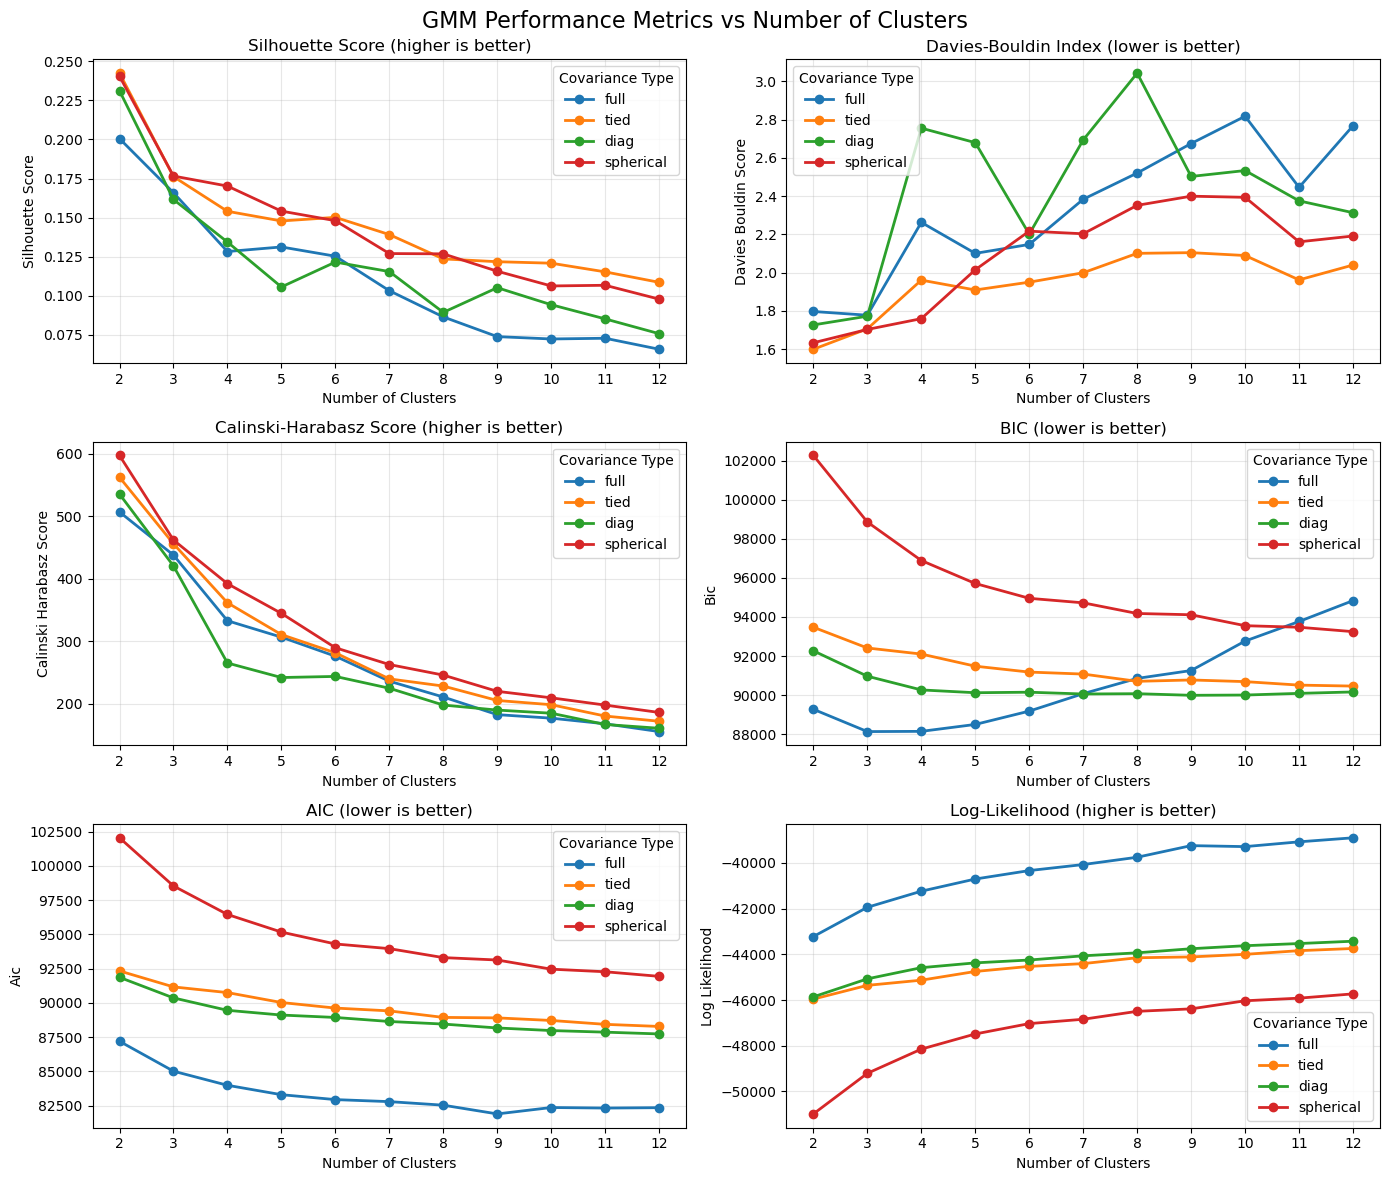


Best GMM Configurations:

Best Silhouette Score: n_clusters                            2
covariance_type                    tied
silhouette_score               0.242481
davies_bouldin_score           1.599326
calinski_harabasz_score      562.053425
bic                        93475.618395
aic                        92336.629954
log_likelihood            -45960.314977
Name: 1, dtype: object

Best Davies-Bouldin Index (lowest): n_clusters                            2
covariance_type                    tied
silhouette_score               0.242481
davies_bouldin_score           1.599326
calinski_harabasz_score      562.053425
bic                        93475.618395
aic                        92336.629954
log_likelihood            -45960.314977
Name: 1, dtype: object

Best BIC (lowest): n_clusters                            3
covariance_type                    full
silhouette_score               0.165931
davies_bouldin_score           1.777352
calinski_harabasz_score      437.736266
bic    

In [56]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Prepare data
pca_final = PCA(n_components=n_components_90)
pca_final_transformed = pca_final.fit_transform(numeric_df_scaled)
X = pca_final_transformed

# Define parameters
covariance_types = ['full', 'tied', 'diag', 'spherical']
n_clusters_range = range(2, 13)  # 2 to 12 clusters

# Store results
gmm_results = []

print("Running GMM analysis for different cluster numbers and covariance types...")
for n_clusters in n_clusters_range:
    for cov_type in covariance_types:
        # Fit GMM
        gmm_model = GaussianMixture(n_components=n_clusters, covariance_type=cov_type, random_state=42)
        gmm_model.fit(X)
        labels = gmm_model.predict(X)
        
        # Calculate metrics
        silhouette = silhouette_score(X, labels)
        davies_bouldin = davies_bouldin_score(X, labels)
        calinski_harabasz = calinski_harabasz_score(X, labels)
        bic = gmm_model.bic(X)
        aic = gmm_model.aic(X)
        log_likelihood = gmm_model.score(X) * len(X)  # Total log-likelihood
        
        # Store results
        gmm_results.append({
            'n_clusters': n_clusters,
            'covariance_type': cov_type,
            'silhouette_score': silhouette,
            'davies_bouldin_score': davies_bouldin,
            'calinski_harabasz_score': calinski_harabasz,
            'bic': bic,
            'aic': aic,
            'log_likelihood': log_likelihood
        })
        
        print(f"n_clusters={n_clusters}, cov_type={cov_type}: Silhouette={silhouette:.4f}, DBI={davies_bouldin:.4f}")

# Convert to DataFrame
gmm_results_df = pd.DataFrame(gmm_results)

# Plot metrics
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('GMM Performance Metrics vs Number of Clusters', fontsize=16)

metrics = [
    ('silhouette_score', 'Silhouette Score (higher is better)'),
    ('davies_bouldin_score', 'Davies-Bouldin Index (lower is better)'),
    ('calinski_harabasz_score', 'Calinski-Harabasz Score (higher is better)'),
    ('bic', 'BIC (lower is better)'),
    ('aic', 'AIC (lower is better)'),
    ('log_likelihood', 'Log-Likelihood (higher is better)')
]

for idx, (metric, title) in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    for cov_type in covariance_types:
        data = gmm_results_df[gmm_results_df['covariance_type'] == cov_type]
        ax.plot(data['n_clusters'], data[metric], marker='o', label=cov_type, linewidth=2)
    
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(title)
    ax.set_xticks(n_clusters_range)
    ax.grid(True, alpha=0.3)
    ax.legend(title='Covariance Type')

plt.tight_layout()
plt.show()

# Print best configurations
print("\n" + "="*60)
print("Best GMM Configurations:")
print("="*60)
print(f"\nBest Silhouette Score: {gmm_results_df.loc[gmm_results_df['silhouette_score'].idxmax()]}")
print(f"\nBest Davies-Bouldin Index (lowest): {gmm_results_df.loc[gmm_results_df['davies_bouldin_score'].idxmin()]}")
print(f"\nBest BIC (lowest): {gmm_results_df.loc[gmm_results_df['bic'].idxmin()]}")
print(f"\nBest AIC (lowest): {gmm_results_df.loc[gmm_results_df['aic'].idxmin()]}")

## Clustering for Attacking Players


| **Defensive Positions** | **Midfield Positions** | **Attacking Positions** |
|---|---|---|
| **GK** - Goalkeepers | **MF** - Midfielders | **FW** - Forwards |
| **DF** - Defenders | **DM** - Defensive Midfielders | **LW** - Left Wingers |
| **FB** - Fullbacks | **CM** - Central Midfielders | **RW** - Right Wingers |
| **LB** - Left Backs | **LM** - Left Midfielders | |
| **RB** - Right Backs | **RM** - Right Midfielders | |
| **CB** - Center Backs | **WM** - Wide Midfielders | |
| | **AM** - Attacking Midfielders | |


In [ ]:
attacking_player_pos = ['MF', 'DM', 'CM', 'LM', 'RM', 'WM', 'AM', 'LW', 'RW', 'SS', 'CF', 'ST', 'FW']

In [ ]:
# Filter attacking player from original dataset - exclude any row containing 'GK' or 'DF'
df_attacking_raw = df[~df['pos'].str.contains('GK|DF', na=False)]
print("Unique positions after filtering:")
print(df_attacking_raw['pos'].unique())
print(f"DataFrame shape: {df_attacking_raw.shape}")

In [ ]:
# Filter duplicate players
df_attacking = df_attacking_raw.drop_duplicates(subset=['player'], keep='first')
print("Players removed due to duplicates:", df_attacking_raw.shape[0] - df_attacking.shape[0])

In [ ]:
# Filter players with less than 450 minutes played and less than 5 matches played
df_attacking_filtered = df_attacking[(df_attacking['Min Playing Time'] >= 450) & (df_attacking['MP Playing Time'] >= 5)]

# Find players with NaN values
players_with_nan = df_attacking_filtered[df_attacking_filtered.isna().any(axis=1)]

# Display columns with NaN values for these players
columns_with_nan = df_attacking_filtered.columns[df_attacking_filtered.isna().any(axis=0)].tolist()
print(f"Number of players with NaN values: {len(players_with_nan)}")
print(f"Columns containing NaN values: {columns_with_nan}")

# Drop players with NaN values
df_attacking_filtered = df_attacking_filtered.dropna()

In [ ]:
columns_90 = ['npxG Per 90 Minutes',
            'G-PK Per 90 Minutes',
            'xAG Per 90 Minutes',
            'xG+xAG Per 90 Minutes',
            'Sh/90 Standard',
            'SoT% Standard',
            "Dist Standard",
            "G/Sh Standard",
            "Cmp% Total",
            "Cmp% Long",
            "Succ% Take-Ons",
            'Won% Aerial Duels',
            ]

columns_to_90s = ['KP',
                    'PrgP',
                    'PPA',
                    'CrsPA',
                    '1/3',
                    'Att Long',
                    'TB Pass Types',
                    'Sw Pass Types',
                    'Crs Pass Types',
                    'PrgC Carries',
                    'CPA Carries',
                    'Succ Take-Ons',
                    'Dis Carries',
                    'Mis Carries',
                    'PrgR Receiving',
                    'TklW Tackles',
                    'Att 3rd Tackles',
                    'Mid 3rd Tackles',
                    'Def 3rd Tackles',
                    'Int',
                    'Sh Blocks',
                    'Recov Performance',
                    'Won Aerial Duels',
                    'Fls Performance',
                    'Fld Performance',
                    'Att Pen Touches',
                    'Att 3rd Touches',
                    'Mid 3rd Touches',
                    'Def 3rd Touches',
                    'Def Pen Touches',
                    'Live Touches',
                    'Cmp Total'
                    ]

print("Number of columns: ", len(columns_90) + len(columns_to_90s))

In [ ]:
# Previous code to analyze column ranges and identify columns storing accumulative counts
# print("Columns", df_attacking_filtered.columns.tolist())

# # Find min and max values for each column
# min_values = df_attacking_scaled.min()
# max_values = df_attacking_scaled.max()
# with open('columns_range_scaled.txt', 'w') as f:
#     for col in df_attacking_scaled.columns:
#         f.write(f"{col}: min={min_values[col]}, max={max_values[col]}\n")

In [ ]:
# Check missing columns
missing_columns = [col for col in df_attacking_filtered.columns if col not in columns_90 + columns_to_90s]
print("Missing columns:", missing_columns)

In [ ]:
# Scale Performance Metrics by 90s (minutes played / 90)
df_attacking_scaled = df_attacking_filtered.copy()
df_attacking_scaled[columns_to_90s] = df_attacking_scaled[columns_to_90s].div(df_attacking_scaled['90s Playing Time'], axis=0).round(2)

In [ ]:
# Prepare final dataset for clustering
# Drop metadata columns AND playing time columns (they shouldn't influence clustering)
droping_columns = ['league', 'team', 'player', 'nation', 'pos', 'season', 'age', 
                   'MP Playing Time', 'Min Playing Time', '90s Playing Time']
df_attacking_final = df_attacking_scaled.drop(columns=droping_columns)

print(f"Final dataset shape: {df_attacking_final.shape}")
print(f"Features for clustering: {df_attacking_final.columns.tolist()}")

In [ ]:
# Standardize the data
scaler = StandardScaler()
df_attacking_final_scaled = scaler.fit_transform(df_attacking_final)   
pca_attacking, pca_transformed_attacking, cumulative_variance_attacking =cumulative_variance_pca(df_attacking_final_scaled)

In [ ]:
# Plot the variance for each PCA component
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(pca_attacking.explained_variance_ratio_) + 1), 
        pca_attacking.explained_variance_ratio_*100, 
        alpha=0.7, 
        color='steelblue',
        edgecolor='black')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained  (%)')
plt.title('Variance Explained by Each PCA Component (Attacking Players)')
plt.xticks(range(1, len(pca_attacking.explained_variance_ratio_) + 1))
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


In [ ]:
attacking_components_95 = np.argmax(cumulative_variance_attacking >= 0.8) + 1

# Get the feature loadings (components) for those principal components
components_attacking = pca_attacking.components_[:attacking_components_95]

# Work with first attacking_components_95 principal components
pca_attacking_final = PCA(n_components=attacking_components_95)
pca_attacking_final_transformed = pca_attacking_final.fit_transform(df_attacking_final_scaled)


In [ ]:
from sklearn.metrics import silhouette_score

best_score = -1
best_params = {}

for eps in np.arange(0.5, 5.0, 0.1):
    for min_samples in [5, 10, 15, 20]:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(pca_attacking_final_transformed)
        
        # Count unique clusters (excluding noise)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        # Ignore if only 1 cluster or all noise or too many clusters
        if n_clusters < 2 or n_clusters > 50: 
            continue
            
        # Filter out noise for score calculation
        core_samples_mask = labels != -1
        n_core_samples = np.sum(core_samples_mask)
        
        # Need at least 2 clusters AND enough non-noise points
        if n_core_samples > 10:
            # Count unique labels in non-noise samples
            unique_clustered_labels = len(set(labels[core_samples_mask]))
            
            # Silhouette requires at least 2 different cluster labels
            if unique_clustered_labels >= 2:
                score = silhouette_score(pca_attacking_final_transformed[core_samples_mask], labels[core_samples_mask])
                if score > best_score:
                    best_score = score
                    best_params = {'eps': eps, 'min_samples': min_samples, 'n_clusters': n_clusters}

print(f"Best Silhouette: {best_score:.4f}, Params: {best_params}")

In [ ]:
# Caluculate MinPts
minPts_attacking = 2 * attacking_components_95
print(f"MinPts for attacking players = 2 * {attacking_components_95} = {minPts_attacking}")

# Use NearestNeighbors to find optimal eps
neighbors_attacking = NearestNeighbors(n_neighbors=minPts_attacking)
neighbors_fit_attacking = neighbors_attacking.fit(pca_attacking_final_transformed)
distances_attacking, indices_attacking = neighbors_fit_attacking.kneighbors(pca_attacking_final_transformed)

# Sort the distances to the minPts-th nearest neighbor
distances_attacking_sorted = np.sort(distances_attacking[:, minPts_attacking-1], axis=0)

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances_attacking_sorted)
plt.xlabel('Data Points (sorted by distance)')
plt.ylabel(f'{minPts_attacking}-NN Distance')
plt.title(f'K-distance Graph for Attacking Players (MinPts={minPts_attacking})\nLook for the "elbow" to determine optimal eps')
plt.grid(True, alpha=0.3)
# Add reference lines
percentiles = [90, 95, 98, 99]
for p in percentiles:
    val = np.percentile(distances_attacking_sorted, p)
    plt.axhline(y=val, linestyle='--', alpha=0.5, label=f'{p}th percentile: {val:.3f}')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Test different eps values and track number of clusters
eps_values_attacking = np.arange(0.5, 10, 0.25)
n_clusters_list_attacking = []
n_noise_list_attacking = []
cluster_info_attacking = [] 


for eps in eps_values_attacking:
    dbscan_attacking = DBSCAN(eps=eps, min_samples=10) # minPts_attacking
    labels_attacking = dbscan_attacking.fit_predict(pca_attacking_final_transformed)
    
    n_clusters = len(set(labels_attacking)) - (1 if -1 in labels_attacking else 0)
    n_noise = list(labels_attacking).count(-1)
    
    n_clusters_list_attacking.append(n_clusters)
    n_noise_list_attacking.append(n_noise)
    cluster_info_attacking.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'n_clustered': len(labels_attacking) - n_noise
    })
    
# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 5))

# Plot 1: Number of clusters vs eps
axes[0].plot(eps_values_attacking, n_clusters_list_attacking, marker='o', linewidth=2, markersize=6)
axes[0].set_xlabel('eps value')
axes[0].set_ylabel('Number of Clusters')
axes[0].set_title(f'Number of Clusters vs eps for Attacking Players (MinPts={minPts_attacking})')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
# Plot 2: Number of noise points and clustered points vs eps
axes[1].plot(eps_values_attacking, n_noise_list_attacking, marker='o', linewidth=2, markersize=6, label='Noise Points', color='red')
axes[1].plot(eps_values_attacking, [len(pca_attacking_final_transformed) - n for n in n_noise_list_attacking], 
             marker='s', linewidth=2, markersize=6, label='Clustered Points', color='green')
axes[1].set_xlabel('eps value')
axes[1].set_ylabel('Number of Points')
axes[1].set_title(f'Noise vs Clustered Points for Attacking Players (MinPts={minPts_attacking})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## K-Means Clustering (Baseline)

In [ ]:
# K-Means clustering with elbow method to find optimal K
from sklearn.cluster import KMeans

# Test different values of K
k_range = range(2, 15)
inertias = []
silhouette_scores = []

print("Testing K-Means with different K values:\n")
print(f"{'K':>3} | {'Inertia':>12} | {'Silhouette':>11}")
print("-" * 40)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pca_attacking_final_transformed)
    
    inertia = kmeans.inertia_
    sil_score = silhouette_score(pca_attacking_final_transformed, labels)
    
    inertias.append(inertia)
    silhouette_scores.append(sil_score)
    
    print(f"{k:>3} | {inertia:>12.2f} | {sil_score:>11.4f}")

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Elbow curve (inertia)
axes[0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)')
axes[0].set_title('Elbow Method for Optimal K')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# Plot 2: Silhouette scores
axes[1].plot(k_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='darkgreen')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs K')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)

# Mark best silhouette score
best_k = k_range[np.argmax(silhouette_scores)]
best_sil = max(silhouette_scores)
axes[1].axvline(x=best_k, color='red', linestyle='--', linewidth=2, label=f'Best K={best_k}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n{'='*40}")
print(f"Best K by Silhouette Score: {best_k} (score: {best_sil:.4f})")

In [ ]:
# Run final clustering with optimal parameters
# DBSCAN with optimal parameters
dbscan_final = DBSCAN(eps=2.3, min_samples=20)
dbscan_labels = dbscan_final.fit_predict(pca_attacking_final_transformed)

# K-Means with K=2 (best silhouette) and K=3 (elbow method)
kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_2_labels = kmeans_2.fit_predict(pca_attacking_final_transformed)

kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_3_labels = kmeans_3.fit_predict(pca_attacking_final_transformed)

print("Clustering Results:")
print(f"\nDBSCAN (eps=2.3, min_samples=20):")
print(f"  Clusters: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")
print(f"  Noise points: {list(dbscan_labels).count(-1)}")
print(f"  Clustered points: {len(dbscan_labels) - list(dbscan_labels).count(-1)}")

print(f"\nK-Means (K=2):")
print(f"  Clusters: {len(set(kmeans_2_labels))}")
for i in range(2):
    print(f"  Cluster {i}: {list(kmeans_2_labels).count(i)} points")

print(f"\nK-Means (K=3):")
print(f"  Clusters: {len(set(kmeans_3_labels))}")
for i in range(3):
    print(f"  Cluster {i}: {list(kmeans_3_labels).count(i)} points")

In [ ]:
# Visualize clusters using first 2 PCA components
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# DBSCAN visualization
scatter1 = axes[0].scatter(pca_attacking_final_transformed[:, 0], 
                          pca_attacking_final_transformed[:, 1],
                          c=dbscan_labels, 
                          cmap='viridis', 
                          alpha=0.6, 
                          s=50,
                          edgecolors='black',
                          linewidth=0.5)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('DBSCAN Clustering\n(eps=2.3, min_samples=20)')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# K-Means K=2 visualization
scatter2 = axes[1].scatter(pca_attacking_final_transformed[:, 0], 
                          pca_attacking_final_transformed[:, 1],
                          c=kmeans_2_labels, 
                          cmap='viridis', 
                          alpha=0.6, 
                          s=50,
                          edgecolors='black',
                          linewidth=0.5)
# Plot centroids
centroids_2 = kmeans_2.cluster_centers_
axes[1].scatter(centroids_2[:, 0], centroids_2[:, 1], 
               marker='X', s=300, c='red', edgecolors='black', linewidth=2, label='Centroids')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('K-Means Clustering (K=2)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

# K-Means K=3 visualization
scatter3 = axes[2].scatter(pca_attacking_final_transformed[:, 0], 
                          pca_attacking_final_transformed[:, 1],
                          c=kmeans_3_labels, 
                          cmap='viridis', 
                          alpha=0.6, 
                          s=50,
                          edgecolors='black',
                          linewidth=0.5)
# Plot centroids
centroids_3 = kmeans_3.cluster_centers_
axes[2].scatter(centroids_3[:, 0], centroids_3[:, 1], 
               marker='X', s=300, c='red', edgecolors='black', linewidth=2, label='Centroids')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
axes[2].set_title('K-Means Clustering (K=3)')
axes[2].grid(True, alpha=0.3)
axes[2].legend()
plt.colorbar(scatter3, ax=axes[2], label='Cluster')

plt.tight_layout()
plt.show()

In [ ]:
# Compare cluster characteristics - get original data back with cluster labels
df_attacking_with_clusters = df_attacking_scaled.copy()

# Add cluster labels
df_attacking_with_clusters['DBSCAN_Cluster'] = dbscan_labels
df_attacking_with_clusters['KMeans_2_Cluster'] = kmeans_2_labels
df_attacking_with_clusters['KMeans_3_Cluster'] = kmeans_3_labels

# Select key performance metrics for comparison
key_metrics = ['npxG Per 90 Minutes', 'xAG Per 90 Minutes', 'G-PK Per 90 Minutes',
               'Sh/90 Standard', 'KP', 'PrgP', 'Succ Take-Ons', 'TklW Tackles', 'Int']

print("="*80)
print("CLUSTER CHARACTERISTICS COMPARISON")
print("="*80)

# DBSCAN clusters
print("\n" + "="*80)
print("DBSCAN CLUSTERS (eps=2.3, min_samples=20)")
print("="*80)
for cluster_id in sorted(set(dbscan_labels)):
    cluster_data = df_attacking_with_clusters[df_attacking_with_clusters['DBSCAN_Cluster'] == cluster_id]
    if cluster_id == -1:
        print(f"\nNoise Points (n={len(cluster_data)}):")
    else:
        print(f"\nCluster {cluster_id} (n={len(cluster_data)}):")
    
    print(f"{'Metric':<25} {'Mean':>10} {'Std':>10}")
    print("-" * 50)
    for metric in key_metrics:
        mean_val = cluster_data[metric].mean()
        std_val = cluster_data[metric].std()
        print(f"{metric:<25} {mean_val:>10.3f} {std_val:>10.3f}")

# K-Means K=2 clusters
print("\n" + "="*80)
print("K-MEANS CLUSTERS (K=2)")
print("="*80)
for cluster_id in range(2):
    cluster_data = df_attacking_with_clusters[df_attacking_with_clusters['KMeans_2_Cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} (n={len(cluster_data)}):")
    
    print(f"{'Metric':<25} {'Mean':>10} {'Std':>10}")
    print("-" * 50)
    for metric in key_metrics:
        mean_val = cluster_data[metric].mean()
        std_val = cluster_data[metric].std()
        print(f"{metric:<25} {mean_val:>10.3f} {std_val:>10.3f}")

# K-Means K=3 clusters
print("\n" + "="*80)
print("K-MEANS CLUSTERS (K=3)")
print("="*80)
for cluster_id in range(3):
    cluster_data = df_attacking_with_clusters[df_attacking_with_clusters['KMeans_3_Cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} (n={len(cluster_data)}):")
    
    print(f"{'Metric':<25} {'Mean':>10} {'Std':>10}")
    print("-" * 50)
    for metric in key_metrics:
        mean_val = cluster_data[metric].mean()
        std_val = cluster_data[metric].std()
        print(f"{metric:<25} {mean_val:>10.3f} {std_val:>10.3f}")

## Agglomerative Hierarchical Clustering

In [ ]:
# Test Agglomerative Clustering with different linkage methods
from sklearn.cluster import AgglomerativeClustering

# Test different linkage methods and number of clusters
linkage_methods = ['ward', 'complete', 'average', 'single']
k_range_agg = range(2, 8)

print("Testing Agglomerative Clustering with different linkages:\n")
print(f"{'Linkage':<12} | {'K':>3} | {'Silhouette':>11}")
print("-" * 40)

best_agg_score = -1
best_agg_params = {}
results_agg = []

for linkage in linkage_methods:
    for k in k_range_agg:
        agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = agg.fit_predict(pca_attacking_final_transformed)
        
        sil_score = silhouette_score(pca_attacking_final_transformed, labels)
        results_agg.append({'linkage': linkage, 'k': k, 'silhouette': sil_score})
        
        print(f"{linkage:<12} | {k:>3} | {sil_score:>11.4f}")
        
        if sil_score > best_agg_score:
            best_agg_score = sil_score
            best_agg_params = {'linkage': linkage, 'k': k}

print(f"\n{'='*40}")
print(f"Best Configuration: {best_agg_params['linkage']} linkage, K={best_agg_params['k']}")
print(f"Silhouette Score: {best_agg_score:.4f}")

In [ ]:
# Visualize silhouette scores for each linkage method
import pandas as pd

results_df = pd.DataFrame(results_agg)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Line plot of silhouette scores
for linkage in linkage_methods:
    linkage_data = results_df[results_df['linkage'] == linkage]
    axes[0].plot(linkage_data['k'], linkage_data['silhouette'], 
                marker='o', linewidth=2, markersize=8, label=linkage)

axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Agglomerative Clustering: Silhouette Score vs K')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range_agg)

# Plot 2: Heatmap of silhouette scores
pivot_table = results_df.pivot(index='linkage', columns='k', values='silhouette')
im = axes[1].imshow(pivot_table.values, cmap='viridis', aspect='auto')
axes[1].set_xticks(range(len(pivot_table.columns)))
axes[1].set_xticklabels(pivot_table.columns)
axes[1].set_yticks(range(len(pivot_table.index)))
axes[1].set_yticklabels(pivot_table.index)
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Linkage Method')
axes[1].set_title('Silhouette Score Heatmap')
plt.colorbar(im, ax=axes[1], label='Silhouette Score')

# Add text annotations
for i in range(len(pivot_table.index)):
    for j in range(len(pivot_table.columns)):
        text = axes[1].text(j, i, f'{pivot_table.values[i, j]:.3f}',
                          ha="center", va="center", color="white", fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Run best Agglomerative configuration and compare with K-Means
agg_best = AgglomerativeClustering(n_clusters=best_agg_params['k'], 
                                   linkage=best_agg_params['linkage'])
agg_best_labels = agg_best.fit_predict(pca_attacking_final_transformed)

# Visualize comparison: K-Means K=3 vs Agglomerative
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# K-Means K=3
scatter1 = axes[0].scatter(pca_attacking_final_transformed[:, 0], 
                          pca_attacking_final_transformed[:, 1],
                          c=kmeans_3_labels, 
                          cmap='viridis', 
                          alpha=0.6, 
                          s=50,
                          edgecolors='black',
                          linewidth=0.5)
centroids_3 = kmeans_3.cluster_centers_
axes[0].scatter(centroids_3[:, 0], centroids_3[:, 1], 
               marker='X', s=300, c='red', edgecolors='black', linewidth=2, label='Centroids')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title(f'K-Means (K=3)\nSilhouette: {silhouette_score(pca_attacking_final_transformed, kmeans_3_labels):.4f}')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Agglomerative best
scatter2 = axes[1].scatter(pca_attacking_final_transformed[:, 0], 
                          pca_attacking_final_transformed[:, 1],
                          c=agg_best_labels, 
                          cmap='viridis', 
                          alpha=0.6, 
                          s=50,
                          edgecolors='black',
                          linewidth=0.5)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title(f'Agglomerative ({best_agg_params["linkage"]}, K={best_agg_params["k"]})\nSilhouette: {best_agg_score:.4f}')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

print(f"\nCluster size distribution:")
print(f"\nK-Means (K=3):")
for i in range(3):
    print(f"  Cluster {i}: {list(kmeans_3_labels).count(i)} points")

print(f"\nAgglomerative ({best_agg_params['linkage']}, K={best_agg_params['k']}):")
for i in range(best_agg_params['k']):
    print(f"  Cluster {i}: {list(agg_best_labels).count(i)} points")

In [ ]:
# Compare cluster characteristics for Agglomerative
df_attacking_with_clusters['Agglomerative_Cluster'] = agg_best_labels

print("="*80)
print(f"AGGLOMERATIVE CLUSTERING ({best_agg_params['linkage']} linkage, K={best_agg_params['k']})")
print("="*80)

for cluster_id in range(best_agg_params['k']):
    cluster_data = df_attacking_with_clusters[df_attacking_with_clusters['Agglomerative_Cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} (n={len(cluster_data)}):")
    
    print(f"{'Metric':<25} {'Mean':>10} {'Std':>10}")
    print("-" * 50)
    for metric in key_metrics:
        mean_val = cluster_data[metric].mean()
        std_val = cluster_data[metric].std()
        print(f"{metric:<25} {mean_val:>10.3f} {std_val:>10.3f}")

# Summary comparison
print("\n" + "="*80)
print("SUMMARY: METHOD COMPARISON")
print("="*80)
print(f"\n{'Method':<30} | {'K':>3} | {'Silhouette':>11} | {'Notes'}")
print("-" * 80)
print(f"{'K-Means':<30} | {2:>3} | {silhouette_score(pca_attacking_final_transformed, kmeans_2_labels):>11.4f} | Attacking vs Defensive")
print(f"{'K-Means':<30} | {3:>3} | {silhouette_score(pca_attacking_final_transformed, kmeans_3_labels):>11.4f} | 3 player archetypes")
print(f"{'DBSCAN (eps=2.3, min=20)':<30} | {1:>3} | {'N/A':>11} | 97.5% noise - too strict")

agg_method_name = f"Agglomerative ({best_agg_params['linkage']})"
print(f"{agg_method_name:<30} | {best_agg_params['k']:>3} | {best_agg_score:>11.4f} | Best hierarchical")

print("\n" + "="*80)
print("RECOMMENDATION:")
print("="*80)
if best_agg_score > silhouette_score(pca_attacking_final_transformed, kmeans_3_labels):
    print(f"✓ Use Agglomerative ({best_agg_params['linkage']} linkage, K={best_agg_params['k']})")
    print(f"  - Highest silhouette score: {best_agg_score:.4f}")
    print(f"  - Better handles non-spherical cluster shapes")
else:
    print(f"✓ Use K-Means (K=3)")
    print(f"  - Silhouette score: {silhouette_score(pca_attacking_final_transformed, kmeans_3_labels):.4f}")
    print(f"  - Clear interpretable player archetypes")
    print(f"  - Simpler and faster than hierarchical methods")